In [1]:
# Importing desired libraries required for the program
!pip --quiet install qiskit_experiments;

import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.visualization import plot_histogram, plot_state_city
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import qiskit_experiments


[notice] A new release of pip available: 23.1.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Using samplers

service = QiskitRuntimeService()
simulation_sampler = Sampler(service.least_busy(simulator=True,operational=True))

## Question 1
### Quantum Fourier Transform

To implement a QFT, our basic ideas are as follows:

- We start off with $n$ qubits (in our case $n = 4$)
- We apply Hadamard gates on all of the n inputs
- We do some controlled rotations using the $cp$ gate
- We swap the qubits to get the output in the right order

If we take $w = 2 \pi \frac iN$, the matrix is as follows:

$$\frac{1}{\sqrt{N}}\begin{bmatrix}
1 & 1 & 1 & \ldots & 1 \\
1 & \omega & \omega^2 & \ldots & \omega^{N-1} \\
1 & \omega^2 & \omega^4 & \ldots & \omega^{2(N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \omega^{N-1} & \omega^{2(N-1)} & \ldots & \omega^{(N-1)(N-1)}
\end{bmatrix}$$

For a 4-bit system, our QFT will be the above case, for $N = 4$.

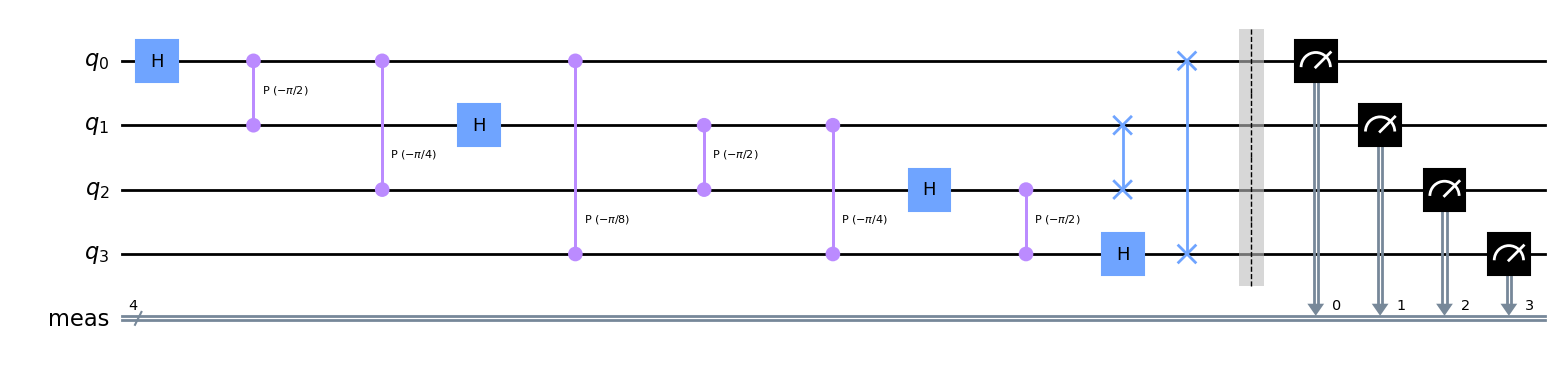

In [3]:
from qiskit.circuit.library import CU1Gate

def qft(n):
    qc = qiskit.QuantumCircuit(n)
    
    # for loop over all the bits
    for j in range(n):
        # h gate on all the bits
        qc.h(j)
        for k in range(j+1, n):
            qc.cp(-2 * np.pi / 2**(k-j+1), k, j)

    # Swapping the qubits to match the output order of the QFT, as it is in reverse order
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)

    qc.measure_all()
        
    return qc
# Create a quantum circuit with 3 qubits
n = 4
qc = qft(n)

# Apply QFT to the first 3 qubits
qc.draw()

base_primitive._run_primitive:INFO:2023-11-30 07:56:08,126: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 10000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


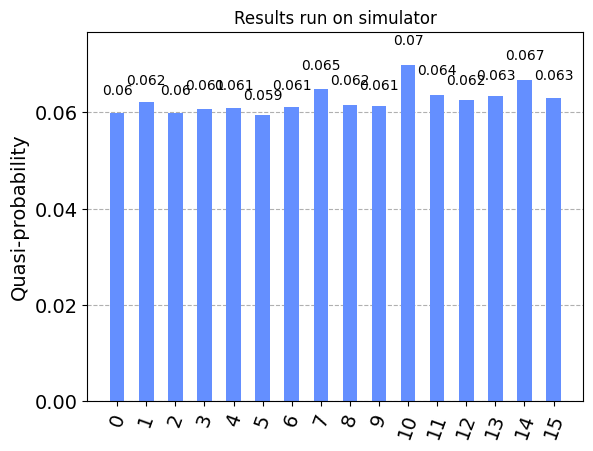

In [4]:
# Plotting the results obtained side-by-side, to ensure that they match

fig, axes = plt.subplots(1, 1)

job_simulation = simulation_sampler.run(qc, shots = 10000)
plot_histogram(job_simulation.result().quasi_dists, ax = axes)
axes.set_title("Results run on simulator");

## Question 2
### Deutsch Josza Algorithm

![Untitled|200x100](Untitled.png)

The Deutsch algorithm can be extended to a function $f : \{ 0, 1 \}^n \to  \{ 0, 1 \}$, and the modified algorithm is called Deutsch-Josza algorithm. This can be used to determine if a function is balanced or constant.

Note that in this case, we want our Oracle to be from $f : \{ 0, 1 \}^n \to \{ 0, 1 \}^n$, but our function has only one output. So, our oracle will be the of the following form: for $n = 2$, our oracle will of course be $\text{Oracle}(a, b) = (a, b \oplus f(x))$.

By considering an analogy with the above Deutsch Algorithm, we measure the first $n$ qubits:

- If we get $| 0 \rangle^{\otimes n}$ with probability $1$, the function is constant
- The function is a balanced function otherwise.

$f(x) = x + xy$ is the given Boolean function.

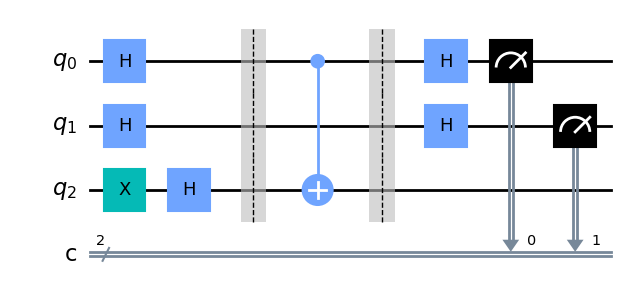

In [5]:
# we have 2 bits
n = 2

qc = qiskit.QuantumCircuit(3, 2)

# applying Hadamard gates on inputs
qc.h(0)
qc.h(1)

# applying X and then H gate on inputs
qc.x(2)
qc.h(2)

qc.barrier()

# Making the oracle
qc.cnot(0, 2)

qc.barrier()

qc.h(0)
qc.h(1)

# Measuring the outputs
qc.measure(0, 0)
qc.measure(1, 1)

qc.draw()

base_primitive._run_primitive:INFO:2023-11-30 07:56:12,726: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


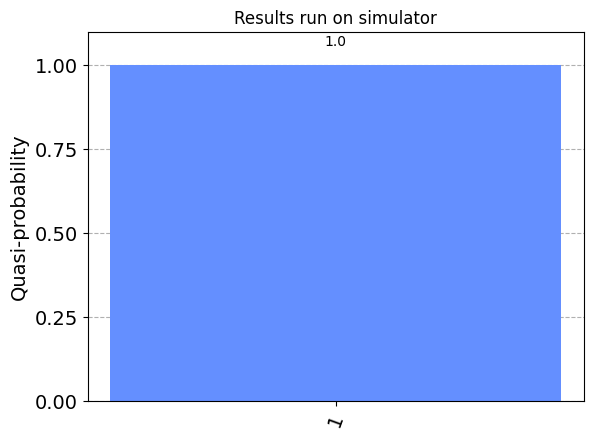

In [6]:
fig, axes = plt.subplots(1, 1)

job_simulation = simulation_sampler.run(qc)
plot_histogram(job_simulation.result().quasi_dists, ax = axes)
axes.set_title("Results run on simulator");

Explanation: We observe a peak at a non-zero value ($|01\rangle$), and *not* at zero. This is justified since the function $f(x) = x + xy = x(1 + y) = x$ is balanced.

## Question 3
### Quantum Phase Estimation

Estimating the phase is an important application of the Quantum Fourier transform.

The various steps are as follows:

- Apply n-bit Hadamard gate, to generate a superposition of all the $2^n$ states
- We apply CU operations (Controlled Unitary operations). This gives us an estimate of the quantum phase (note that it is not exact)
- We apply Inverse QFT, with the matrix as follows:
$$\frac{1}{\sqrt{N}}\begin{bmatrix}
1 & 1 & 1 & \ldots & 1 \\
1 & \omega^{-1} & \omega^{-2} & \ldots & \omega^{-(N-1)} \\
1 & \omega^{-2} & \omega^{-4} & \ldots & \omega^{-2(N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \omega^{-(N-1)} & \omega^{-2(N-1)} & \ldots & \omega^{-(N-1)(N-1)}
\end{bmatrix}$$
- We measure all of the first n bits

In out case, for angle $\frac{\pi}{2}$ (because $e^{i \frac \pi 2} = i$), two bits are enough for getting exact solution, but we will use 3 bits for demonstration

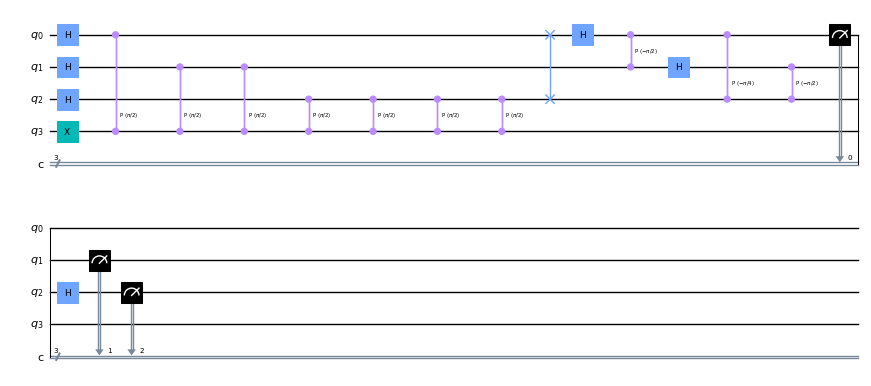

In [7]:
def qft_inverse(qc, n):

    # Inverse QFT, reverse process as Question 1
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/(2**(j-m)), m, j)
        qc.h(j)

# We're using n = 3 counting bits here, plus one more bit which has the actual phase
        
qc = qiskit.QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qc.h(qubit)

qc.x(3)

# Do the controlled-U operations:
angle = np.pi/2
repetitions = 1
for qubit in range(3):
    for i in range(repetitions):
        qc.cp(angle, qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qft_inverse(qc, 3)

# Measureing the n qubits
for n in range(3):
    qc.measure(n,n)

qc.draw(scale = 0.5)

base_primitive._run_primitive:INFO:2023-11-30 07:56:17,176: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}


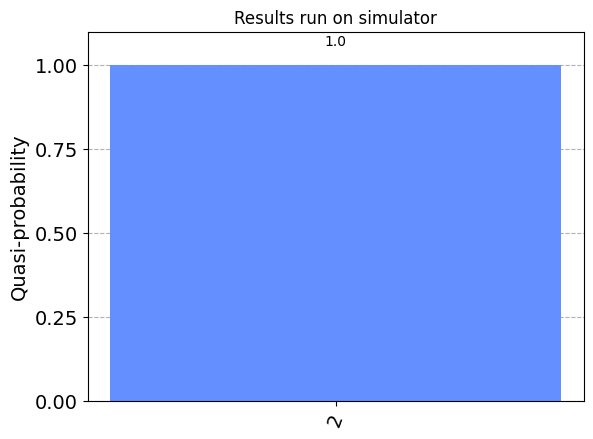

In [8]:
fig, axes = plt.subplots(1, 1);

job_simulation = simulation_sampler.run(qc);
plot_histogram(job_simulation.result().quasi_dists, ax = axes);
axes.set_title("Results run on simulator");

Explanation: We got a maximum at 2.
To find the phase, we divide 2 by $2^n$, so we get $\frac 14$.

From this, our phase = $\frac 14  2 \pi = \frac{\pi}{2}$, as expected!